Designed by: Thomas Vakili (thomas.vakili@dsv.su.se)

# Lab 3: Named Entitity Recognition and Bias

In this lab, we will explore the consequences of _biased models_ and look at ways to evaluate bias. Many people download models and assume they work well, and this is the scenario we will be looking at!

## Setting up the environment
First, you need to configure the environment. I suggest using `virtualenv` and `pip` to set up the environment:
```
virtualenv ner
source ner/bin/activate
pip install -r requirements.txt
```

Then make sure that Jupyter is running in the `venv` environment. One way to guarantee that this is the case is to run `jupyter notebook` after `pip` has finished installing the packages.

In [2]:
import transformers
import pandas as pd
import datasets
from datasets import load_metric
from transformers import AutoTokenizer
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification
import numpy as np

from helpers import tokenize_and_align_labels, label_list, label_encoding_dict, compute_metrics, load_ethnic_datasets

import torch

MODEL_TYPE = "bert-base-uncased"
batch_size = 16

In [3]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_TYPE)

model = AutoModelForTokenClassification.from_pretrained('./sketchy_bert_ner.model', num_labels=len(label_list))

model.config.label2id = label_encoding_dict
model.config.id2label = {idx: label for idx, label in enumerate(label_list)}

data_collator = DataCollatorForTokenClassification(tokenizer)

# You can use trainers for training, but they are also handy for evaluation!
trainer = Trainer(
    model,
    None,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

Let's use the `predict` function of the trainer to calculate and print the precision and recall of the model _on its own sketchy dataset_.

In [4]:
sketchy_val = datasets.Dataset.load_from_disk('sketchy_ner_data.val')
sketchy_val_tokenized = sketchy_val.map(tokenize_and_align_labels(tokenizer), batched=True)

# What is the precision and recall of this model?
y_preds = trainer.predict(sketchy_val_tokenized)

Loading cached processed dataset at sketchy_ner_data.val/cache-949427ead7c12a59.arrow
The following columns in the test set  don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: ner_tags, tokens.
***** Running Prediction *****
  Num examples = 3250
  Batch size = 8
100%|█████████▉| 406/407 [00:45<00:00,  7.39it/s]

In [4]:
y_preds.metrics

{'test_loss': 0.060290828347206116,
 'test_precision': 0.9419992300782754,
 'test_recall': 0.9475926164967085,
 'test_f1': 0.9447876447876449,
 'test_accuracy': 0.9873694437697352,
 'test_runtime': 47.0981,
 'test_samples_per_second': 69.005,
 'test_steps_per_second': 8.642}

Looks pretty good, right? But we are a bit skeptical about the quality of this data. Let's evaluate the model using the well-established CoNLL 2003 dataset.

In [5]:
conll = datasets.load_dataset('conll2003')

conll_val = conll['validation']
conll_val_tokenized = conll_val.map(tokenize_and_align_labels(tokenizer), batched=True)

# Find the precision and recall for the CoNLL 2003 validation set
conll_predict = trainer.predict(conll_val_tokenized)

Reusing dataset conll2003 (/Users/ludviglundberg/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/63f4ebd1bcb7148b1644497336fd74643d4ce70123334431a3c053b7ee4e96ee)
100%|██████████| 3/3 [00:00<00:00, 595.47it/s]
Loading cached processed dataset at /Users/ludviglundberg/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/63f4ebd1bcb7148b1644497336fd74643d4ce70123334431a3c053b7ee4e96ee/cache-da64bb5dda1ccc74.arrow
The following columns in the test set  don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: id, chunk_tags, pos_tags, ner_tags, tokens.
***** Running Prediction *****
  Num examples = 3251
  Batch size = 8
813it [01:34,  7.44it/s]                         

In [6]:
conll_predict.metrics

{'test_loss': 0.5413238406181335,
 'test_precision': 0.6769112139237717,
 'test_recall': 0.6874370734981542,
 'test_f1': 0.6821335405450408,
 'test_accuracy': 0.928431855370391,
 'test_runtime': 47.9191,
 'test_samples_per_second': 67.844,
 'test_steps_per_second': 8.493}

Looks like it performs much worse! But why? Complete the code and create a confusion matrix.

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import scipy

logits, labels = conll_predict.predictions, conll_predict.label_ids


In [8]:
def num_to_label(index):
    if index == -100:
        return "-"
    return label_list[index]

In [9]:
# First, convert the logits to the actual predictions (hint: you can use numpy)
#predictions = 
# Extract all predicted and true values using the predictions and labels
to_label = np.vectorize(num_to_label)

y_preds = to_label(np.argmax(logits, axis=2).flatten())
y_trues = to_label(labels.flatten())
# Look at the sklearn documentation to figure out the formatting required
confusion_matrix = metrics.confusion_matrix(y_trues, y_preds, labels=label_list)

[Text(0, 0.5, 'O'),
 Text(0, 1.5, 'B-PER'),
 Text(0, 2.5, 'I-PER'),
 Text(0, 3.5, 'B-ORG'),
 Text(0, 4.5, 'I-ORG'),
 Text(0, 5.5, 'B-LOC'),
 Text(0, 6.5, 'I-LOC'),
 Text(0, 7.5, 'B-MISC'),
 Text(0, 8.5, 'I-MISC')]

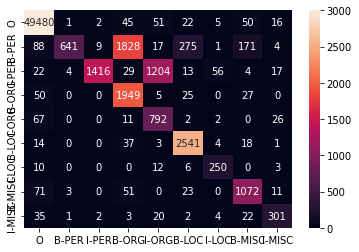

In [10]:
ax = plt.subplot()
sns.heatmap(confusion_matrix, annot=True, fmt='g', ax=ax, vmax=3000, vmin=0)
ax.xaxis.set_ticklabels(label_list)
ax.yaxis.set_ticklabels(label_list)

Looks like there is a problem with how names are being classified!

# Gender Bias

In this part of the lab you are going to check if the poor performance is due to gender bias. This is a common problem in many models because of skewed datasets.

You will use the following dataset, from [Mehrabi et al. (2020)](https://dl.acm.org/doi/pdf/10.1145/3372923.3404804), which you should clone from GitHub:

In [11]:
# %%sh 
# git clone https://github.com/Ninarehm/NERGenderBias.git

In [12]:
from helpers import load_gendered_samples
female_samples, male_samples = load_gendered_samples()

female_samples[:10]

['Kharsyn is a person',
 'Felisa is eating food',
 'Ellyott is going to school',
 'Leeandra is going to grocery shop',
 'Kerriana is at school',
 'Yianna is eating food',
 'Seaanna is a doctor',
 'Nikeya is going to school',
 'Kabrea is going to grocery shop',
 'Forrest is a person']

Now, let's run these samples through the NER tagger!

In [5]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_TYPE)
model = AutoModelForTokenClassification.from_pretrained('./sketchy_bert_ner.model')

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /Users/ludviglundberg/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.16.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-base-un

In [29]:
from transformers import pipeline
pipe_sketchy = pipeline("ner",  model=model, tokenizer=tokenizer, aggregation_strategy='simple')

In [ ]:

male_pred_sketchy = pipe_sketchy(male_samples)
female_pred_sketchy = pipe_sketchy(female_samples)

male_samples_pred_corr_sketchy = sum(1 for pred in male_pred_sketchy if 'PER' in list(map(lambda x: x['entity_group'], pred)) )
male_sample_count_sketchy = len(male_samples)

print("male: predicted: {}, total: {}, accuracy(%): {} ".format(male_samples_pred_corr_sketchy, male_sample_count_sketchy, male_samples_pred_corr_sketchy/male_sample_count_sketchy))

female_samples_pred_corr_sketchy = sum(1 for pred in female_pred_sketchy if 'PER' in list(map(lambda x: x['entity_group'], pred)) )
female_sample_count_sketchy = len(female_samples)

print("female: predicted: {}, total: {}, accuracy(%): {} ".format(female_samples_pred_corr_sketchy, female_sample_count_sketchy, female_samples_pred_corr_sketchy/female_sample_count_sketchy))

In [29]:
from transformers import pipeline

# Create a NER pipeline! Make sure to configure it to _aggregate_ the WordPieces into whole words.
pipe = pipeline("ner", aggregation_strategy='simple')

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english)
https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english/resolve/main/config.json not found in cache or force_download set to True, downloading to /Users/ludviglundberg/.cache/huggingface/transformers/tmp6aja_f2t
Downloading: 100%|██████████| 998/998 [00:00<00:00, 519kB/s]
storing https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english/resolve/main/config.json in cache at /Users/ludviglundberg/.cache/huggingface/transformers/dbfd3b2eb181c7b63cbbd8e7773a5e64941849440953d50ecad5ef346ad8286a.8f943745c8dd5e96d7b60c9b9e1be5711aff8aff42413b74288e076022e6e2bf
creating metadata file for /Users/ludviglundberg/.cache/huggingface/transformers/dbfd3b2eb181c7b63cbbd8e7773a5e64941849440953d50ecad5ef346ad8286a.8f943745c8dd5e96d7b60c9b9e1be5711aff8aff42413b74288e076022e6e2bf
loading configuration file https://huggi

In [30]:
# Now let's run the classifier over the female samples and the male samples
male_pred = pipe(male_samples)
female_pred = pipe(female_samples)

In [31]:
male_pred

[[{'entity_group': 'PER',
   'score': 0.9955826,
   'word': 'Derean',
   'start': 0,
   'end': 6}],
 [{'entity_group': 'PER',
   'score': 0.9831127,
   'word': 'Ezan',
   'start': 0,
   'end': 4}],
 [{'entity_group': 'PER',
   'score': 0.9972444,
   'word': 'Nessiah',
   'start': 0,
   'end': 7}],
 [{'entity_group': 'PER',
   'score': 0.99169946,
   'word': 'Omi',
   'start': 0,
   'end': 3}],
 [{'entity_group': 'PER',
   'score': 0.99149203,
   'word': 'Draike',
   'start': 0,
   'end': 6}],
 [{'entity_group': 'PER',
   'score': 0.9846667,
   'word': 'Ameen',
   'start': 0,
   'end': 5}],
 [{'entity_group': 'PER',
   'score': 0.9972979,
   'word': 'Olman',
   'start': 0,
   'end': 5}],
 [{'entity_group': 'PER',
   'score': 0.99353456,
   'word': 'Pavan',
   'start': 0,
   'end': 5}],
 [{'entity_group': 'PER',
   'score': 0.9968592,
   'word': 'Taige',
   'start': 0,
   'end': 5}],
 [{'entity_group': 'PER',
   'score': 0.992886,
   'word': 'Gianny',
   'start': 0,
   'end': 6}],
 [{'en

In [32]:
male_pred_count = map(lambda word: list(filter(lambda token_pred : 'PER' in token_pred['entity_group'], word)), male_pred)
len(list(filter(lambda x : x != [], male_pred_count)))

4830

In [33]:
male_samples_pred_corr = sum(1 for pred in male_pred if 'PER' in list(map(lambda x: x['entity_group'], pred)) )
male_sample_count = len(male_samples)

print("male: predicted: {}, total: {}, accuracy(%): {} ".format(male_samples_pred_corr, male_sample_count, male_samples_pred_corr/male_sample_count))

female_samples_pred_corr = sum(1 for pred in female_pred if 'PER' in list(map(lambda x: x['entity_group'], pred)) )
female_sample_count = len(female_samples)

print("female: predicted: {}, total: {}, accuracy(%): {} ".format(female_samples_pred_corr, female_sample_count, female_samples_pred_corr/female_sample_count))

male: predicted: 4830, total: 5000, accuracy(%): 0.966 
female: predicted: 4829, total: 5000, accuracy(%): 0.9658 


In [20]:
# With these predictions, calculate the per-gender accuracy.
# Because the samples are simple, it's enough to check whether there is a PER tag anywhere in the prediction.


The results indicate that gender bias plays a role. But it seems like there is something more going on...

# Ethnic biases

Another common problem is _ethnic bias_. Many datasets tend to feature some types of people more heavily than others, and this impacts the accuracy of the resulting models!

In this part of the lab, we will use an approach described by [Mishra et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020arXiv200803415M/abstract):

In [7]:
ethnic_datasets = load_ethnic_datasets() # CoNLL 2003 data processed like in Mishra et al. (2020)
print(ethnic_datasets.keys())

Reusing dataset conll2003 (/Users/ludviglundberg/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/63f4ebd1bcb7148b1644497336fd74643d4ce70123334431a3c053b7ee4e96ee)


dict_keys(['bm', 'bf', 'wm', 'wf', 'hm', 'hf', 'mm', 'mf'])


In [23]:
ethnic_datasets['bm']['ner_tags']

[[0, 0, 5, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 [1, 2],
 [5,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  7,
  0,
  1,
  2,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  7,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1,
  2,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  2,
  0,
  0,
  0,
  7,
  0,
  0,
  0,
  1,
  2,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [0,
  1,
  2,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0],
 [1, 2, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0],
 [5, 0, 1, 2, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0],
 [3, 4, 0, 1, 0, 0, 5, 0, 0, 0, 0],
 [5, 0, 1, 2],
 [1,
  0,
  0,
  0,
  1,
  2,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
 

In [21]:
ethnic_datasets['bm']['tokens']

[['SOCCER',
  '-',
  'JAPAN',
  'GET',
  'LUCKY',
  'WIN',
  ',',
  'Lionel',
  'IN',
  'SURPRISE',
  'DEFEAT',
  '.'],
 ['Tyree', 'Ladki'],
 ['China',
  'controlled',
  'most',
  'of',
  'the',
  'match',
  'and',
  'saw',
  'several',
  'chances',
  'missed',
  'until',
  'the',
  '78th',
  'minute',
  'when',
  'Uzbek',
  'striker',
  'Leroy',
  'Shkvyrin',
  'took',
  'advantage',
  'of',
  'a',
  'misdirected',
  'defensive',
  'header',
  'to',
  'lob',
  'the',
  'ball',
  'over',
  'the',
  'advancing',
  'Chinese',
  'keeper',
  'and',
  'into',
  'an',
  'empty',
  'net',
  '.'],
 ['Terrence',
  'Shatskiku',
  'made',
  'sure',
  'of',
  'the',
  'win',
  'in',
  'injury',
  'time',
  ',',
  'hitting',
  'an',
  'unstoppable',
  'left',
  'foot',
  'shot',
  'from',
  'just',
  'outside',
  'the',
  'area',
  '.'],
 ['Jerome',
  'Takagi',
  'scored',
  'the',
  'winner',
  'in',
  'the',
  '88th',
  'minute',
  ',',
  'rising',
  'to',
  'head',
  'a',
  'Lionel',
  'Yanagimo

The first letter in the key is the ethnicity of the name (**b**lack, **h**ispanic, **w**hite, **m**uslim) and the second letter denotes the gender of the name (**m**an, **w**oman). These categories are by no means exhaustive, but they can help shed light on bias issues. Calculate the precision and recall for each group:

In [39]:
model.__dict__


trainer = Trainer(
    model,
    None,
    compute_metrics=compute_metrics
)

{'training': False,
 '_parameters': OrderedDict(),
 '_buffers': OrderedDict(),
 '_non_persistent_buffers_set': set(),
 '_backward_hooks': OrderedDict(),
 '_is_full_backward_hook': None,
 '_forward_hooks': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_modules': OrderedDict([('bert',
               BertModel(
                 (embeddings): BertEmbeddings(
                   (word_embeddings): Embedding(30522, 768, padding_idx=0)
                   (position_embeddings): Embedding(512, 768)
                   (token_type_embeddings): Embedding(2, 768)
                   (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
                   (dropout): Dropout(p=0.1, inplace=False)
                 )
                 (encoder): BertEncoder(
                   (layer): ModuleList(
                     (0): BertLayer(
                       (attention): BertAttention(
                  

In [37]:
for category, data in ethnic_datasets.items():
    print(model.predict((data['tokens'])))

AttributeError: 'BertForTokenClassification' object has no attribute 'predict'

Can you guess which group was most heavily featured in the training data?

## Questions!

*_What if the bias did not have to do with persons, but with locations. How would you approach the problem of uncovering such biases?_*

*_Thankfully, you had a second less problematic dataset at hand. What could have been an alternative way of dealing with the bias?_*

*_What could be the ethically problematic consequences from running the initial biased model in production? What would the results look like - and what information would be missed?_*

You can write your answers here or in a separate document. Be prepared to discuss these questions at the lab session!

## Bonus: examples of biased ML

https://www.theguardian.com/technology/2016/mar/24/tay-microsofts-ai-chatbot-gets-a-crash-course-in-racism-from-twitter

https://www.theverge.com/21298762/face-depixelizer-ai-machine-learning-tool-pulse-stylegan-obama-bias

https://www.telegraph.co.uk/technology/2018/10/10/amazon-scraps-sexist-ai-recruiting-tool-showed-bias-against/

https://www.wired.com/2009/12/hp-notebooks-racist/

https://github.com/daviddao/awful-ai